<a href="https://colab.research.google.com/github/RoshanV1701/CaptionGenerator/blob/main/captionGenAIResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import pandas as pd

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cat '/content/drive/My Drive/ML Links/caption_link.txt'
!wget -i '/content/drive/My Drive/ML Links/caption_link.txt'

http://nlp.stanford.edu/data/glove.6B.zip
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip--2022-09-19 11:30:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-19 11:30:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-19 11:30:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting 

In [4]:
!unzip glove.6B.zip -d glove.6B/

Archive:  glove.6B.zip
  inflating: glove.6B/glove.6B.50d.txt  
  inflating: glove.6B/glove.6B.100d.txt  
  inflating: glove.6B/glove.6B.200d.txt  
  inflating: glove.6B/glove.6B.300d.txt  


In [5]:
!unzip Flickr8k_Dataset.zip -d Flickr8k_Dataset//

Streaming output truncated to the last 5000 lines.
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: Flickr8k_Dataset//Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: Flickr8k_Dataset//Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: Flickr8k_Dataset//Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: Flickr8k_Dataset//Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: Flickr8k_Dataset//Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: Flickr8k_Dataset//__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: Flickr8k_Dataset//Flicke

In [6]:
!unzip Flickr8k_text.zip -d Flickr8k_text/

Archive:  Flickr8k_text.zip
  inflating: Flickr8k_text/CrowdFlowerAnnotations.txt  
  inflating: Flickr8k_text/ExpertAnnotations.txt  
  inflating: Flickr8k_text/Flickr8k.lemma.token.txt  
   creating: Flickr8k_text/__MACOSX/
  inflating: Flickr8k_text/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Flickr8k_text/Flickr8k.token.txt  
  inflating: Flickr8k_text/Flickr_8k.devImages.txt  
  inflating: Flickr8k_text/Flickr_8k.testImages.txt  
  inflating: Flickr8k_text/Flickr_8k.trainImages.txt  
  inflating: Flickr8k_text/readme.txt  


In [7]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join('Flickr8k_text','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]


In [8]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


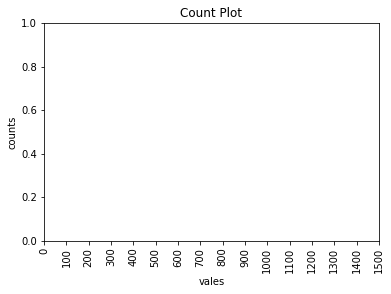

In [9]:



plt.title("Count Plot")
plt.xlabel("vales")
plt.xticks(np.arange(0,1600,100),rotation=90)
plt.ylabel('counts')
plt.show()

In [10]:
img = glob.glob(os.path.join('Flickr8k_Dataset','Flicker8k_Dataset', '*.jpg'))

In [11]:
len(img)

8091

In [12]:
train_images_path = os.path.join('Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join('Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [13]:

print(len(train_images))
print(len(test_images))

6000
1000


In [14]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

len(train_descriptions)


6000

In [15]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 0s 0us/step


In [16]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:

def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [18]:
train_path = os.path.join(f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join('Flickr8k_Dataset','Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

100%|██████████| 6000/6000 [08:35<00:00, 11.64it/s]


In [19]:
test_path = os.path.join(f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join('Flickr8k_Dataset','Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [01:25<00:00, 11.74it/s]


In [20]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [21]:

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [22]:

idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [23]:
max_length +=2
print(max_length)

34


In [24]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [25]:

glove_dir = os.path.join('glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:12, 31134.25it/s]

Found 400000 word vectors.


In [26]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector



embedding_matrix.shape



(1652, 200)

In [27]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [28]:
caption_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      330400      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [29]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [30]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [31]:
model_path = os.path.join(f'caption-model.hdf5')
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
else:
  caption_model.load_weights(model_path)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


2000/2000 [==============================] - 201s 98ms/step - loss: 4.1291


  5%|▌         | 1/20 [03:20<1:03:37, 200.94s/it]

2000/2000 [==============================] - 198s 99ms/step - loss: 3.4263


 10%|█         | 2/20 [06:39<59:47, 199.31s/it]  

2000/2000 [==============================] - 195s 97ms/step - loss: 3.2089


 15%|█▌        | 3/20 [09:53<55:52, 197.19s/it]

2000/2000 [==============================] - 195s 97ms/step - loss: 3.0751


 20%|██        | 4/20 [13:08<52:20, 196.27s/it]

2000/2000 [==============================] - 193s 97ms/step - loss: 2.9791


 25%|██▌       | 5/20 [16:21<48:47, 195.20s/it]

2000/2000 [==============================] - 194s 97ms/step - loss: 2.9052


 30%|███       | 6/20 [19:36<45:28, 194.91s/it]

2000/2000 [==============================] - 198s 99ms/step - loss: 2.8469


 35%|███▌      | 7/20 [22:53<42:25, 195.79s/it]

2000/2000 [==============================] - 199s 100ms/step - loss: 2.7980


 40%|████      | 8/20 [26:12<39:22, 196.83s/it]

2000/2000 [==============================] - 202s 101ms/step - loss: 2.7572


 45%|████▌     | 9/20 [29:35<36:24, 198.59s/it]

2000/2000 [==============================] - 200s 100ms/step - loss: 2.7218


 50%|█████     | 10/20 [32:57<33:16, 199.62s/it]

2000/2000 [==============================] - 201s 100ms/step - loss: 2.6917


 55%|█████▌    | 11/20 [36:18<30:00, 200.03s/it]

2000/2000 [==============================] - 200s 100ms/step - loss: 2.6651


 60%|██████    | 12/20 [39:38<26:40, 200.07s/it]

2000/2000 [==============================] - 199s 99ms/step - loss: 2.6392


 65%|██████▌   | 13/20 [42:57<23:17, 199.67s/it]

2000/2000 [==============================] - 200s 100ms/step - loss: 2.6195


 70%|███████   | 14/20 [46:19<20:02, 200.36s/it]

2000/2000 [==============================] - 198s 99ms/step - loss: 2.6029


 75%|███████▌  | 15/20 [49:41<16:44, 200.84s/it]

2000/2000 [==============================] - 200s 100ms/step - loss: 2.5857


 80%|████████  | 16/20 [53:01<13:22, 200.70s/it]

2000/2000 [==============================] - 195s 97ms/step - loss: 2.5674


 85%|████████▌ | 17/20 [56:23<10:03, 201.07s/it]

2000/2000 [==============================] - 196s 98ms/step - loss: 2.5528


 90%|█████████ | 18/20 [59:39<06:39, 199.57s/it]

2000/2000 [==============================] - 198s 99ms/step - loss: 2.5425


 95%|█████████▌| 19/20 [1:02:57<03:19, 199.24s/it]

2000/2000 [==============================] - 201s 101ms/step - loss: 2.5275


100%|██████████| 20/20 [1:06:19<00:00, 198.96s/it]

   1/1000 [..............................] - ETA: 2:10 - loss: 2.5034


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


1000/1000 [==============================] - 108s 108ms/step - loss: 2.3683


In [32]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Flickr8k_Dataset/Flicker8k_Dataset/3074842262_62b1b2168c.jpg


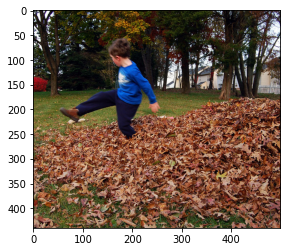

Caption: little girl in pink dress is running through grassy area
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/2928152792_b16c73434a.jpg


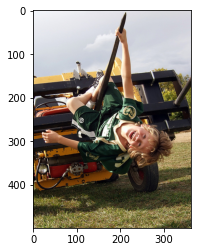

Caption: man in red shirt is sitting on the grass with his legs outstretched
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/2196846255_2c1635359a.jpg


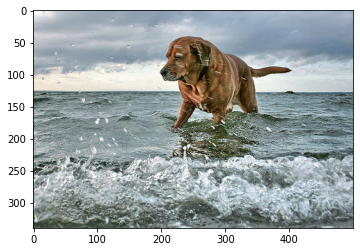

Caption: brown dog is running through the water
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/494792770_2c5f767ac0.jpg


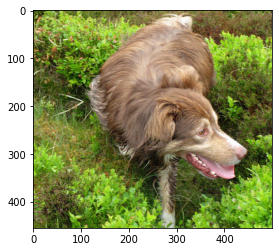

Caption: two dogs are playing with red ball in grassy field
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/398662202_97e5819b79.jpg


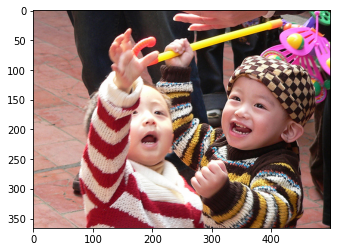

Caption: two girls are playing with purple ribbon
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/3108197858_441ff38565.jpg


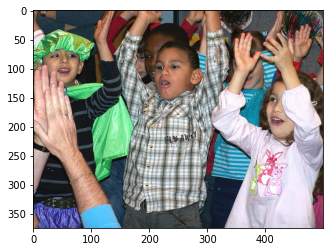

Caption: two girls are posing for picture with their arms around each other
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/3234401637_84e0d14414.jpg


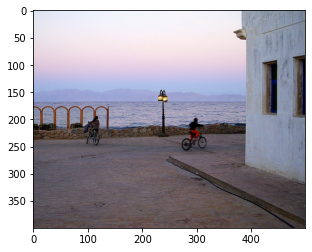

Caption: man in blue shirt and hat grinding on his skateboard
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/3344233740_c010378da7.jpg


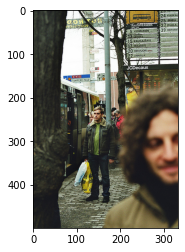

Caption: man in red jacket and woman in black jacket walking down the street
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/2554081584_233bdf289a.jpg


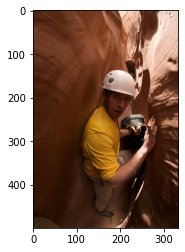

Caption: man in red shirt is standing on top of ridge
_____________________________________
Flickr8k_Dataset/Flicker8k_Dataset/2529116152_4331dabf50.jpg


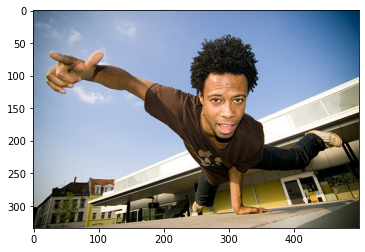

Caption: man in red shirt is standing on his hand on the sidewalk
_____________________________________


In [33]:

for z in range(10):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join('Flickr8k_Dataset','Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join('Flickr8k_Dataset','Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")